## Importing Libraries

In [1]:
# Libraries to be used for project
# Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
#from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
#import cufflinks as cf
from collections import defaultdict
from collections import Counter
#from imblearn.over_sampling import SMOTE

## Loading of data into MongoDB

In [2]:
from pymongo import MongoClient
client = MongoClient()

In [3]:
client = MongoClient('localhost', 27017)

In [4]:
mydb = client["amazonPhones"] 
my_collection = mydb['phoneReviews'] 

In [5]:
import bson
import json
import dateutil 
import parser
from bson.json_util import loads

In [6]:
with open('outputWithNPCountAndSentiment.json', 'r') as f:
    data = json.load(f)

all_reviews = []

for record in data:
    for review in record['reviewList']:
        all_reviews.append(review)

# test print uncomment to view
# for i in range(10):
#     print(all_reviews[i])

FileNotFoundError: [Errno 2] No such file or directory: 'outputWithNPCountAndSentiment.json'

In [7]:
# This will throw an error (duplicate key) but it works
converted = loads(json.dumps(all_reviews))
my_collection.insert_many(converted)

NameError: name 'all_reviews' is not defined

## Dataset Details

In [6]:
# loading into Pandas DataFrame
cursor = my_collection.find()
df = pd.DataFrame(list(cursor))

# Data set summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57348 entries, 0 to 57347
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               57348 non-null  object
 1   overall           57348 non-null  int64 
 2   verified          57348 non-null  bool  
 3   reviewTime        57348 non-null  object
 4   reviewerID        57348 non-null  object
 5   asin              57348 non-null  object
 6   style             26487 non-null  object
 7   reviewerName      57340 non-null  object
 8   reviewText        57316 non-null  object
 9   summary           57331 non-null  object
 10  unixReviewTime    57348 non-null  int64 
 11  nounPhrasesCount  57348 non-null  object
 12  sentiment         57316 non-null  object
 13  image             549 non-null    object
 14  vote              10806 non-null  object
dtypes: bool(1), int64(2), object(12)
memory usage: 6.2+ MB
None


In [7]:
# Sample view of the data
df.head()

_id  overall  verified   reviewTime      reviewerID  \
0  641664ab9a51903fe2caffe9        5      True  08 21, 2018  A2C8N6W0XPYJB0   
1  641664ab9a51903fe2cb0000        5      True  07 19, 2018  A3GK98D7JMR41X   
2  641664ab9a51903fe2cb0009        1      True   07 3, 2018   AQHXZAFT2UTS8   
3  641664ab9a51903fe2cb000c        5      True   07 2, 2018  A3OFF4F1AZHOPE   
4  641664ab9a51903fe2cb0010        5      True  06 23, 2018  A1NNNEPCM14OGF   

         asin                      style      reviewerName  \
0  B00YD547Q6  {'Color:': ' Space Gray'}       Andrade2005   
1  B00YD547Q6  {'Color:': ' Space Gray'}  Russell V. Lewey   
2  B00YD547Q6  {'Color:': ' Space Gray'}              Zero   
3  B00YD547Q6        {'Color:': ' Gold'}      Delroy Jones   
4  B00YD547Q6      {'Color:': ' Silver'}          Erick R!   

                                          reviewText  \
0              very good, just what I needed, I love   
1  Bought this phone for my Mom.  It looked brand...   
2  The phone which should be cmda unlocked would ...   
3                                               Good   
4                                         Very good!   

                           summary  unixReviewTime  \
0             good product quality      1534809600   
1                         Like New      1531958400   
2  Stay away from these on Verizon      1530576000   
3                             Nice      1530489600   
4                       Five Stars      1529712000   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment image vote  
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   NaN  NaN  
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   NaN  NaN  
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   NaN  NaN  
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   NaN  NaN  
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   NaN  NaN

## Preprocessing and cleaning

In [8]:
process_reviews = df.copy()
process_reviews.isnull().sum()

_id                     0
overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style               30861
reviewerName            8
reviewText             32
summary                17
unixReviewTime          0
nounPhrasesCount        0
sentiment              32
image               56799
vote                46542
dtype: int64

In [9]:
# Handle null values
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

# Concatenating review text and summary
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']

## Remove all irrelevant fields
process_reviews=process_reviews.drop(['image', 'vote', 'summary'], axis=1)

# 
process_reviews.head()

_id  overall  verified   reviewTime      reviewerID  \
0  641664ab9a51903fe2caffe9        5      True  08 21, 2018  A2C8N6W0XPYJB0   
1  641664ab9a51903fe2cb0000        5      True  07 19, 2018  A3GK98D7JMR41X   
2  641664ab9a51903fe2cb0009        1      True   07 3, 2018   AQHXZAFT2UTS8   
3  641664ab9a51903fe2cb000c        5      True   07 2, 2018  A3OFF4F1AZHOPE   
4  641664ab9a51903fe2cb0010        5      True  06 23, 2018  A1NNNEPCM14OGF   

         asin                      style      reviewerName  \
0  B00YD547Q6  {'Color:': ' Space Gray'}       Andrade2005   
1  B00YD547Q6  {'Color:': ' Space Gray'}  Russell V. Lewey   
2  B00YD547Q6  {'Color:': ' Space Gray'}              Zero   
3  B00YD547Q6        {'Color:': ' Gold'}      Delroy Jones   
4  B00YD547Q6      {'Color:': ' Silver'}          Erick R!   

                                          reviewText  unixReviewTime  \
0              very good, just what I needed, I love      1534809600   
1  Bought this phone for my Mom.  It looked brand...      1531958400   
2  The phone which should be cmda unlocked would ...      1530576000   
3                                               Good      1530489600   
4                                         Very good!      1529712000   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews  
0  very good, just what I needed, I lovegood prod...  
1  Bought this phone for my Mom.  It looked brand...  
2  The phone which should be cmda unlocked would ...  
3                                           GoodNice  
4                               Very good!Five Stars

In [10]:
# distribution of ratings
process_reviews['overall'].value_counts()

5    36386
4     8872
1     5093
3     4379
2     2618
Name: overall, dtype: int64

In [11]:
#This function returns sentiment value based on the overall ratings from the user
def f(row):
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [12]:
#Applying the function in our new column
process_reviews['scoreSentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

_id  overall  verified   reviewTime      reviewerID  \
0  641664ab9a51903fe2caffe9        5      True  08 21, 2018  A2C8N6W0XPYJB0   
1  641664ab9a51903fe2cb0000        5      True  07 19, 2018  A3GK98D7JMR41X   
2  641664ab9a51903fe2cb0009        1      True   07 3, 2018   AQHXZAFT2UTS8   
3  641664ab9a51903fe2cb000c        5      True   07 2, 2018  A3OFF4F1AZHOPE   
4  641664ab9a51903fe2cb0010        5      True  06 23, 2018  A1NNNEPCM14OGF   

         asin                      style      reviewerName  \
0  B00YD547Q6  {'Color:': ' Space Gray'}       Andrade2005   
1  B00YD547Q6  {'Color:': ' Space Gray'}  Russell V. Lewey   
2  B00YD547Q6  {'Color:': ' Space Gray'}              Zero   
3  B00YD547Q6        {'Color:': ' Gold'}      Delroy Jones   
4  B00YD547Q6      {'Color:': ' Silver'}          Erick R!   

                                          reviewText  unixReviewTime  \
0              very good, just what I needed, I love      1534809600   
1  Bought this phone for my Mom.  It looked brand...      1531958400   
2  The phone which should be cmda unlocked would ...      1530576000   
3                                               Good      1530489600   
4                                         Very good!      1529712000   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment  
0  very good, just what I needed, I lovegood prod...       Positive  
1  Bought this phone for my Mom.  It looked brand...       Positive  
2  The phone which should be cmda unlocked would ...       Negative  
3                                           GoodNice       Positive  
4                               Very good!Five Stars       Positive

In [13]:
process_reviews['scoreSentiment'].value_counts()

Positive    45258
Negative     7711
Neutral      4379
Name: scoreSentiment, dtype: int64

## Handling time column
#### review time column which has date and year, we split both we will split the date further into month and date.

In [14]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

_id  overall  verified      reviewerID        asin  \
0  641664ab9a51903fe2caffe9        5      True  A2C8N6W0XPYJB0  B00YD547Q6   
1  641664ab9a51903fe2cb0000        5      True  A3GK98D7JMR41X  B00YD547Q6   
2  641664ab9a51903fe2cb0009        1      True   AQHXZAFT2UTS8  B00YD547Q6   
3  641664ab9a51903fe2cb000c        5      True  A3OFF4F1AZHOPE  B00YD547Q6   
4  641664ab9a51903fe2cb0010        5      True  A1NNNEPCM14OGF  B00YD547Q6   

                       style      reviewerName  \
0  {'Color:': ' Space Gray'}       Andrade2005   
1  {'Color:': ' Space Gray'}  Russell V. Lewey   
2  {'Color:': ' Space Gray'}              Zero   
3        {'Color:': ' Gold'}      Delroy Jones   
4      {'Color:': ' Silver'}          Erick R!   

                                          reviewText  unixReviewTime  \
0              very good, just what I needed, I love      1534809600   
1  Bought this phone for my Mom.  It looked brand...      1531958400   
2  The phone which should be cmda unlocked would ...      1530576000   
3                                               Good      1530489600   
4                                         Very good!      1529712000   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment   date  \
0  very good, just what I needed, I lovegood prod...       Positive  08 21   
1  Bought this phone for my Mom.  It looked brand...       Positive  07 19   
2  The phone which should be cmda unlocked would ...       Negative   07 3   
3                                           GoodNice       Positive   07 2   
4                               Very good!Five Stars       Positive  06 23   

    year  
0   2018  
1   2018  
2   2018  
3   2018  
4   2018

In [15]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

_id  overall  verified      reviewerID        asin  \
0  641664ab9a51903fe2caffe9        5      True  A2C8N6W0XPYJB0  B00YD547Q6   
1  641664ab9a51903fe2cb0000        5      True  A3GK98D7JMR41X  B00YD547Q6   
2  641664ab9a51903fe2cb0009        1      True   AQHXZAFT2UTS8  B00YD547Q6   
3  641664ab9a51903fe2cb000c        5      True  A3OFF4F1AZHOPE  B00YD547Q6   
4  641664ab9a51903fe2cb0010        5      True  A1NNNEPCM14OGF  B00YD547Q6   

                       style      reviewerName  \
0  {'Color:': ' Space Gray'}       Andrade2005   
1  {'Color:': ' Space Gray'}  Russell V. Lewey   
2  {'Color:': ' Space Gray'}              Zero   
3        {'Color:': ' Gold'}      Delroy Jones   
4      {'Color:': ' Silver'}          Erick R!   

                                          reviewText  unixReviewTime  \
0              very good, just what I needed, I love      1534809600   
1  Bought this phone for my Mom.  It looked brand...      1531958400   
2  The phone which should be cmda unlocked would ...      1530576000   
3                                               Good      1530489600   
4                                         Very good!      1529712000   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment   year  \
0  very good, just what I needed, I lovegood prod...       Positive   2018   
1  Bought this phone for my Mom.  It looked brand...       Positive   2018   
2  The phone which should be cmda unlocked would ...       Negative   2018   
3                                           GoodNice       Positive   2018   
4                               Very good!Five Stars       Positive   2018   

  month day  
0    08  21  
1    07  19  
2    07   3  
3    07   2  
4    06  23

## Review text-Punctuation Cleaning
### Let's begin our text processing by removing the punctuations

In [16]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [17]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

_id  overall  verified      reviewerID        asin  \
0  641664ab9a51903fe2caffe9        5      True  A2C8N6W0XPYJB0  B00YD547Q6   
1  641664ab9a51903fe2cb0000        5      True  A3GK98D7JMR41X  B00YD547Q6   
2  641664ab9a51903fe2cb0009        1      True   AQHXZAFT2UTS8  B00YD547Q6   
3  641664ab9a51903fe2cb000c        5      True  A3OFF4F1AZHOPE  B00YD547Q6   
4  641664ab9a51903fe2cb0010        5      True  A1NNNEPCM14OGF  B00YD547Q6   

                       style  \
0  {'Color:': ' Space Gray'}   
1  {'Color:': ' Space Gray'}   
2  {'Color:': ' Space Gray'}   
3        {'Color:': ' Gold'}   
4      {'Color:': ' Silver'}   

                                          reviewText  \
0              very good, just what I needed, I love   
1  Bought this phone for my Mom.  It looked brand...   
2  The phone which should be cmda unlocked would ...   
3                                               Good   
4                                         Very good!   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment   year  \
0  very good just what i needed i lovegood produc...       Positive   2018   
1  bought this phone for my mom  it looked brand ...       Positive   2018   
2  the phone which should be cmda unlocked would ...       Negative   2018   
3                                           goodnice       Positive   2018   
4                                very goodfive stars       Positive   2018   

  month day  
0    08  21  
1    07  19  
2    07   3  
3    07   2  
4    06  23

## Review text-Stop words
### General nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). We have curated the stop words which doesn't have any negative sentiment or any negative alternatives.

In [19]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [20]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

_id  overall  verified      reviewerID        asin  \
0  641664ab9a51903fe2caffe9        5      True  A2C8N6W0XPYJB0  B00YD547Q6   
1  641664ab9a51903fe2cb0000        5      True  A3GK98D7JMR41X  B00YD547Q6   
2  641664ab9a51903fe2cb0009        1      True   AQHXZAFT2UTS8  B00YD547Q6   
3  641664ab9a51903fe2cb000c        5      True  A3OFF4F1AZHOPE  B00YD547Q6   
4  641664ab9a51903fe2cb0010        5      True  A1NNNEPCM14OGF  B00YD547Q6   

                       style  \
0  {'Color:': ' Space Gray'}   
1  {'Color:': ' Space Gray'}   
2  {'Color:': ' Space Gray'}   
3        {'Color:': ' Gold'}   
4      {'Color:': ' Silver'}   

                                          reviewText  \
0              very good, just what I needed, I love   
1  Bought this phone for my Mom.  It looked brand...   
2  The phone which should be cmda unlocked would ...   
3                                               Good   
4                                         Very good!   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment   year  \
0               good needed lovegood product quality       Positive   2018   
1  bought phone mom looked brand new checked work...       Positive   2018   
2  phone cmda unlocked would not activate verizon...       Negative   2018   
3                                           goodnice       Positive   2018   
4                                     goodfive stars       Positive   2018   

  month day  
0    08  21  
1    07  19  
2    07   3  
3    07   2  
4    06  23

## Year vs Sentiment count¶
### In this block we will see how many reviews were posted based on sentiments in each year from 2004 to 2014

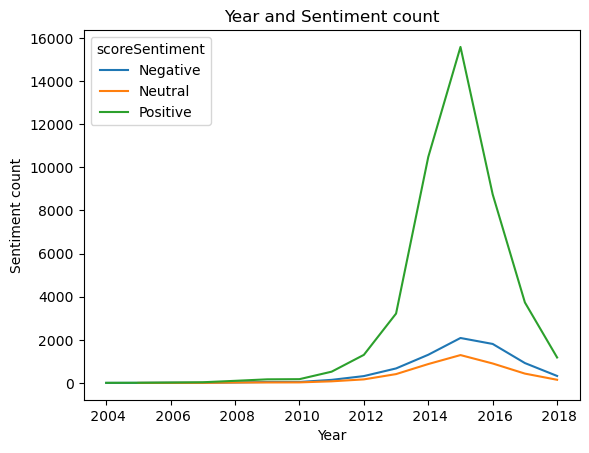

In [21]:
process_reviews.groupby(['year','scoreSentiment'])['scoreSentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

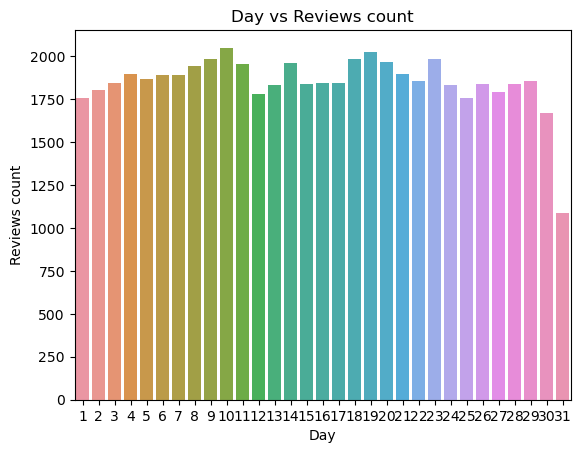

In [22]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

## Creating few more features for text analysis
#### Now, let's create polarity, review length and word count

#### Review length: length of the review which includes each letters and spaces

#### Word length: This measures how many words are there in review

In [23]:
# not able to execute this step because of TextBlob import issue
#process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))
process_reviews.head()

_id  overall  verified      reviewerID        asin  \
0  641664ab9a51903fe2caffe9        5      True  A2C8N6W0XPYJB0  B00YD547Q6   
1  641664ab9a51903fe2cb0000        5      True  A3GK98D7JMR41X  B00YD547Q6   
2  641664ab9a51903fe2cb0009        1      True   AQHXZAFT2UTS8  B00YD547Q6   
3  641664ab9a51903fe2cb000c        5      True  A3OFF4F1AZHOPE  B00YD547Q6   
4  641664ab9a51903fe2cb0010        5      True  A1NNNEPCM14OGF  B00YD547Q6   

                       style  \
0  {'Color:': ' Space Gray'}   
1  {'Color:': ' Space Gray'}   
2  {'Color:': ' Space Gray'}   
3        {'Color:': ' Gold'}   
4      {'Color:': ' Silver'}   

                                          reviewText  \
0              very good, just what I needed, I love   
1  Bought this phone for my Mom.  It looked brand...   
2  The phone which should be cmda unlocked would ...   
3                                               Good   
4                                         Very good!   

                                    nounPhrasesCount  \
0                                                 {}   
1  {'bought': 1, 'this phone': 1, 'my mom': 1, 'b...   
2  {'the phone': 1, 'verizon worked fine': 1, 'a ...   
3                                                 {}   
4                                                 {}   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...   
1  {'neg': 0.055, 'neu': 0.775, 'pos': 0.17, 'com...   
2  {'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.223, 'pos': 0.777, 'comp...   

                                             reviews scoreSentiment   year  \
0               good needed lovegood product quality       Positive   2018   
1  bought phone mom looked brand new checked work...       Positive   2018   
2  phone cmda unlocked would not activate verizon...       Negative   2018   
3                                           goodnice       Positive   2018   
4                                     goodfive stars       Positive   2018   

  month day  review_len  word_count  
0    08  21          36           5  
1    07  19         150          21  
2    07   3          87          14  
3    07   2           8           1  
4    06  23          14           2

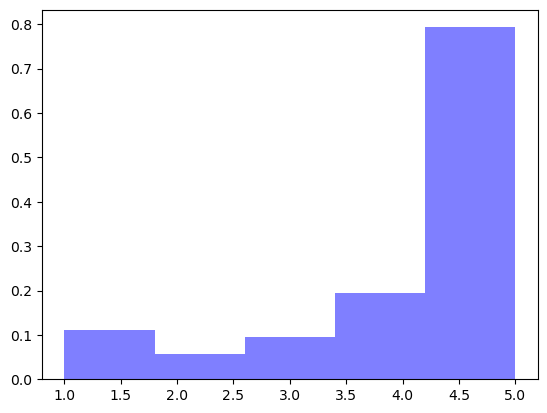

In [24]:
# distribution of overall rating
plt.hist(process_reviews['overall'], 5,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

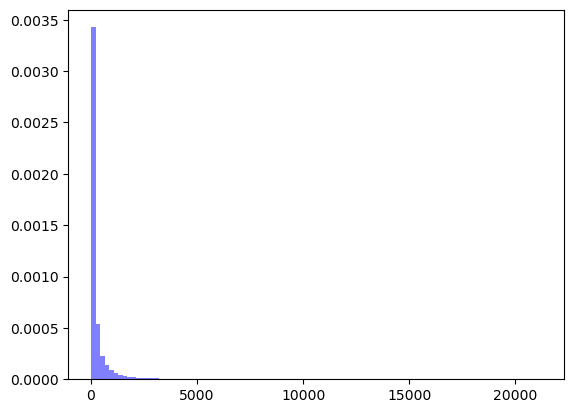

In [25]:
# distribution of review length, not sure if this is helpful
plt.hist(process_reviews['review_len'], 100,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

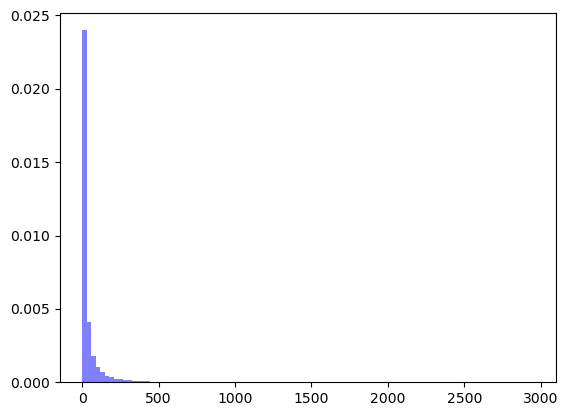

In [26]:
# distribution of word counr, not sure if this is helpful
plt.hist(process_reviews['word_count'], 100,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [27]:
#Filtering data
review_pos = process_reviews[process_reviews["scoreSentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["scoreSentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["scoreSentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

In [28]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

In [29]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

### Positive Word cloud

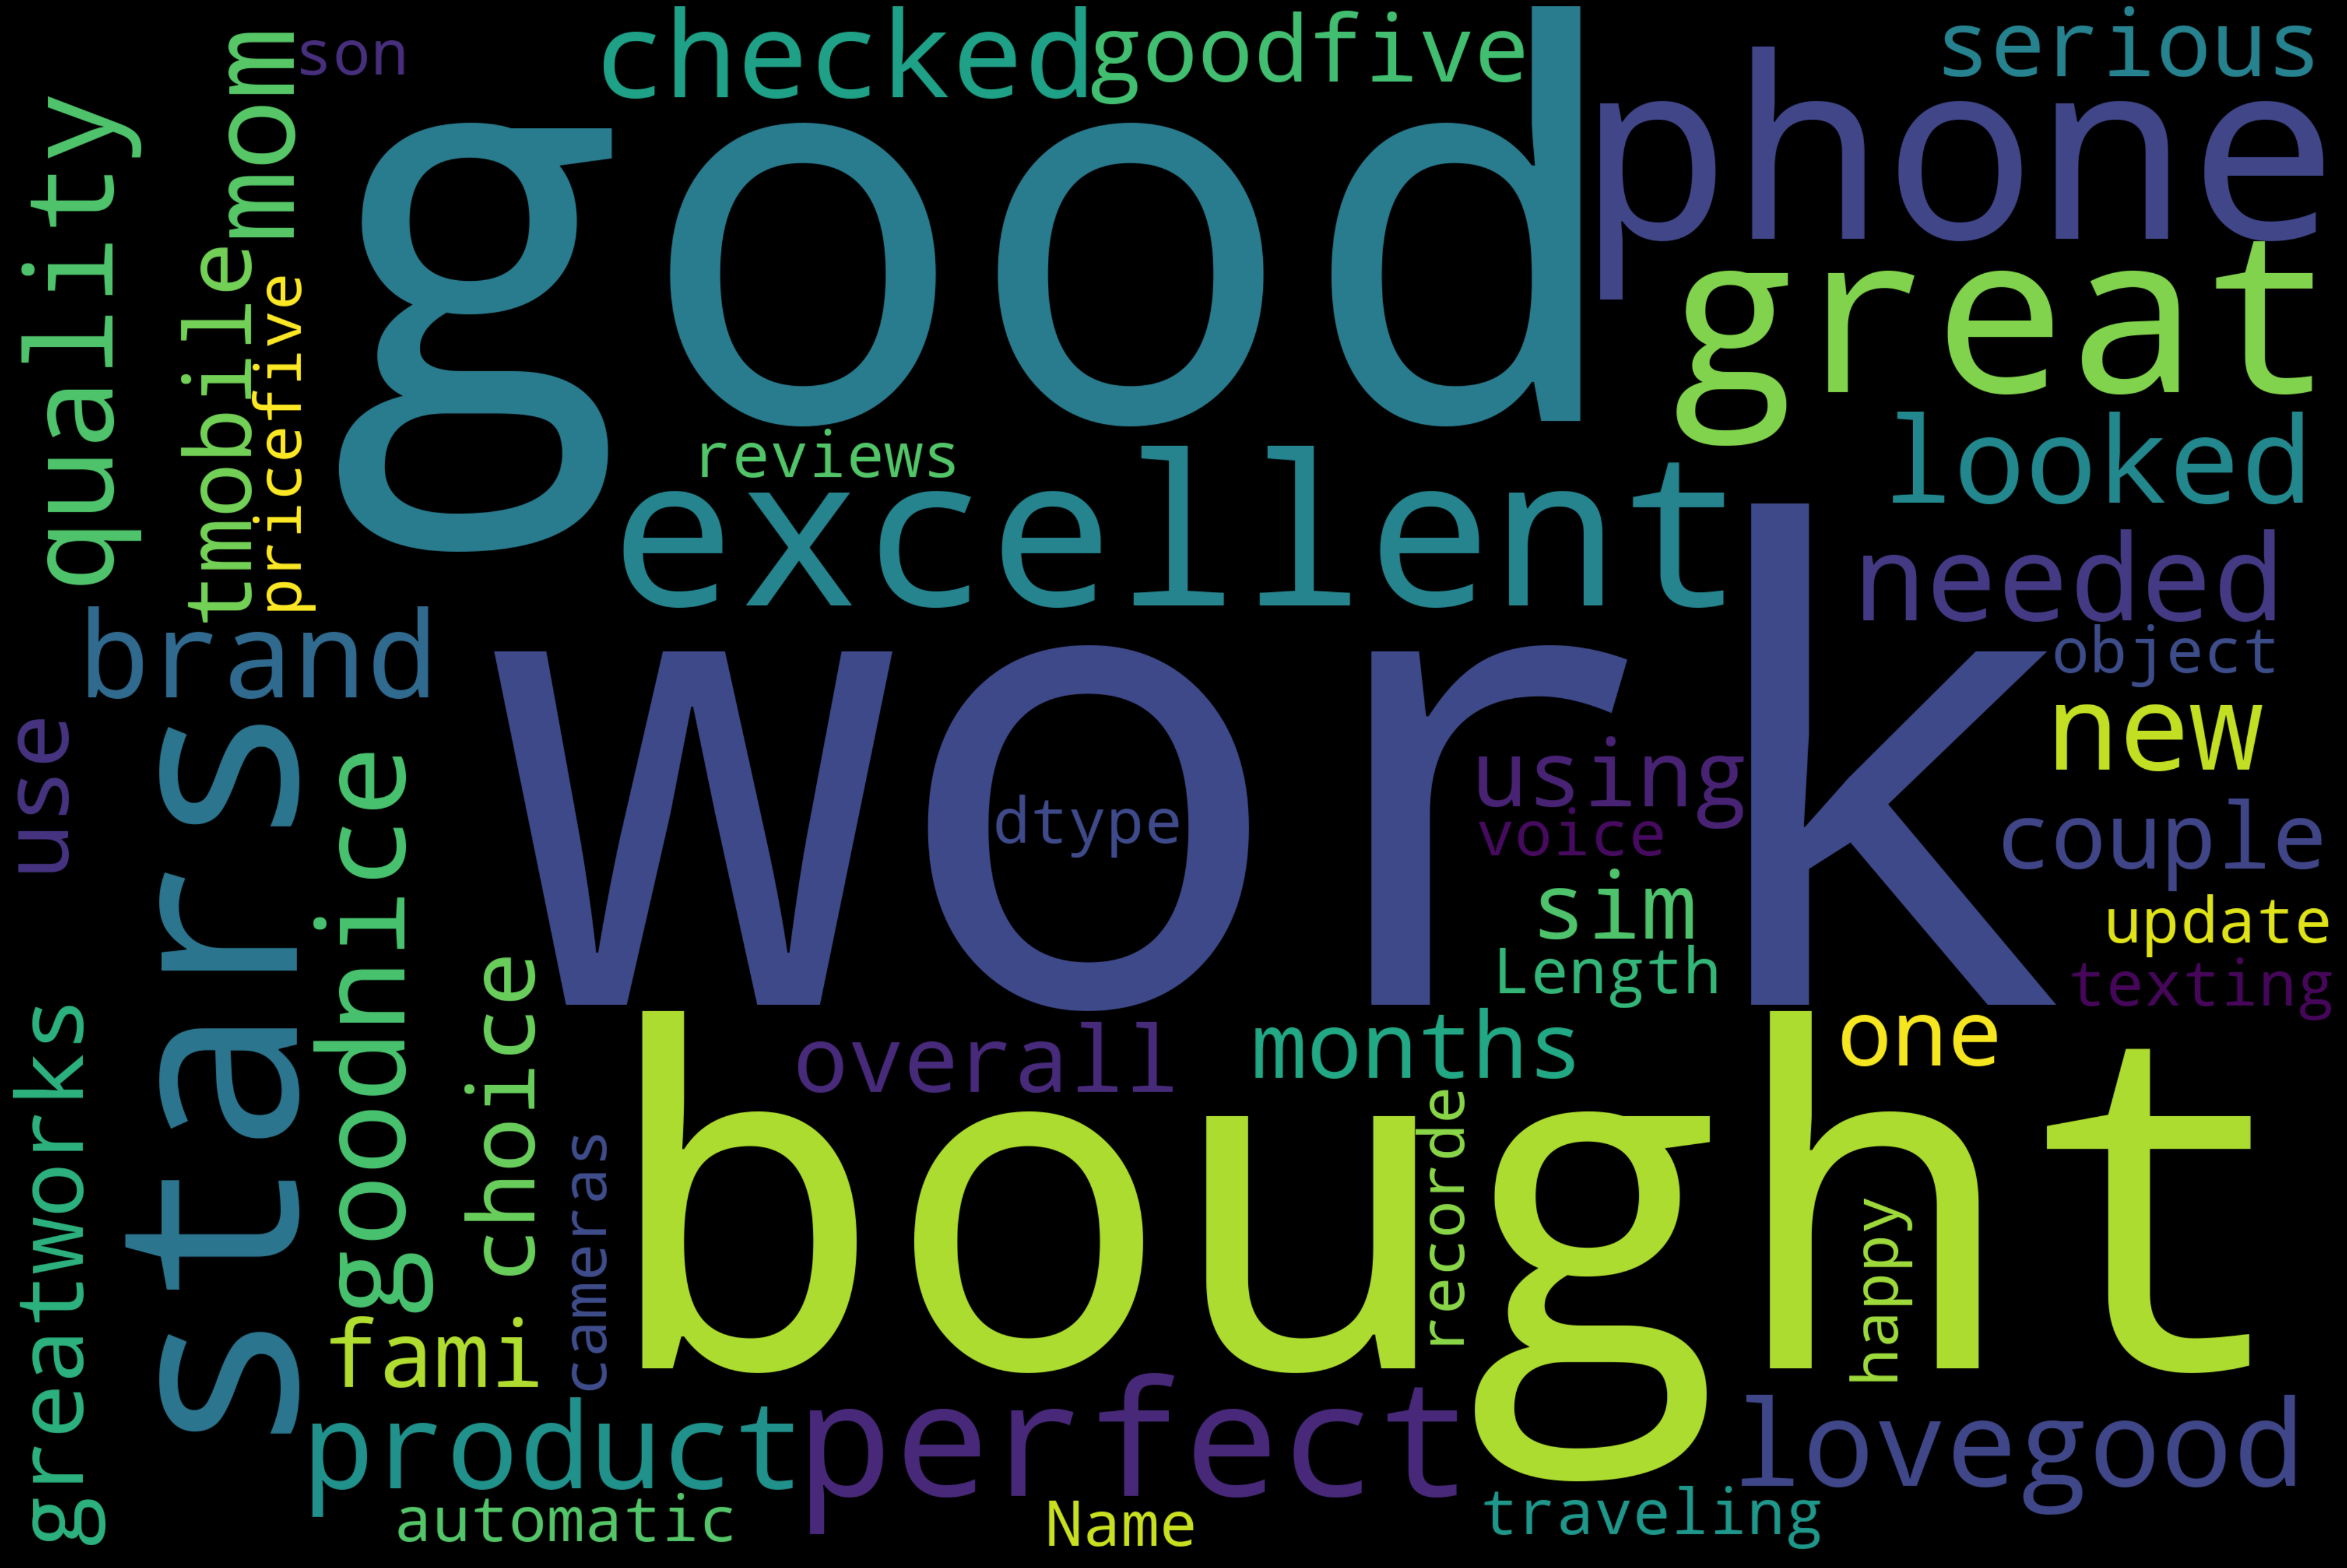

In [30]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Neutral Word Cloud

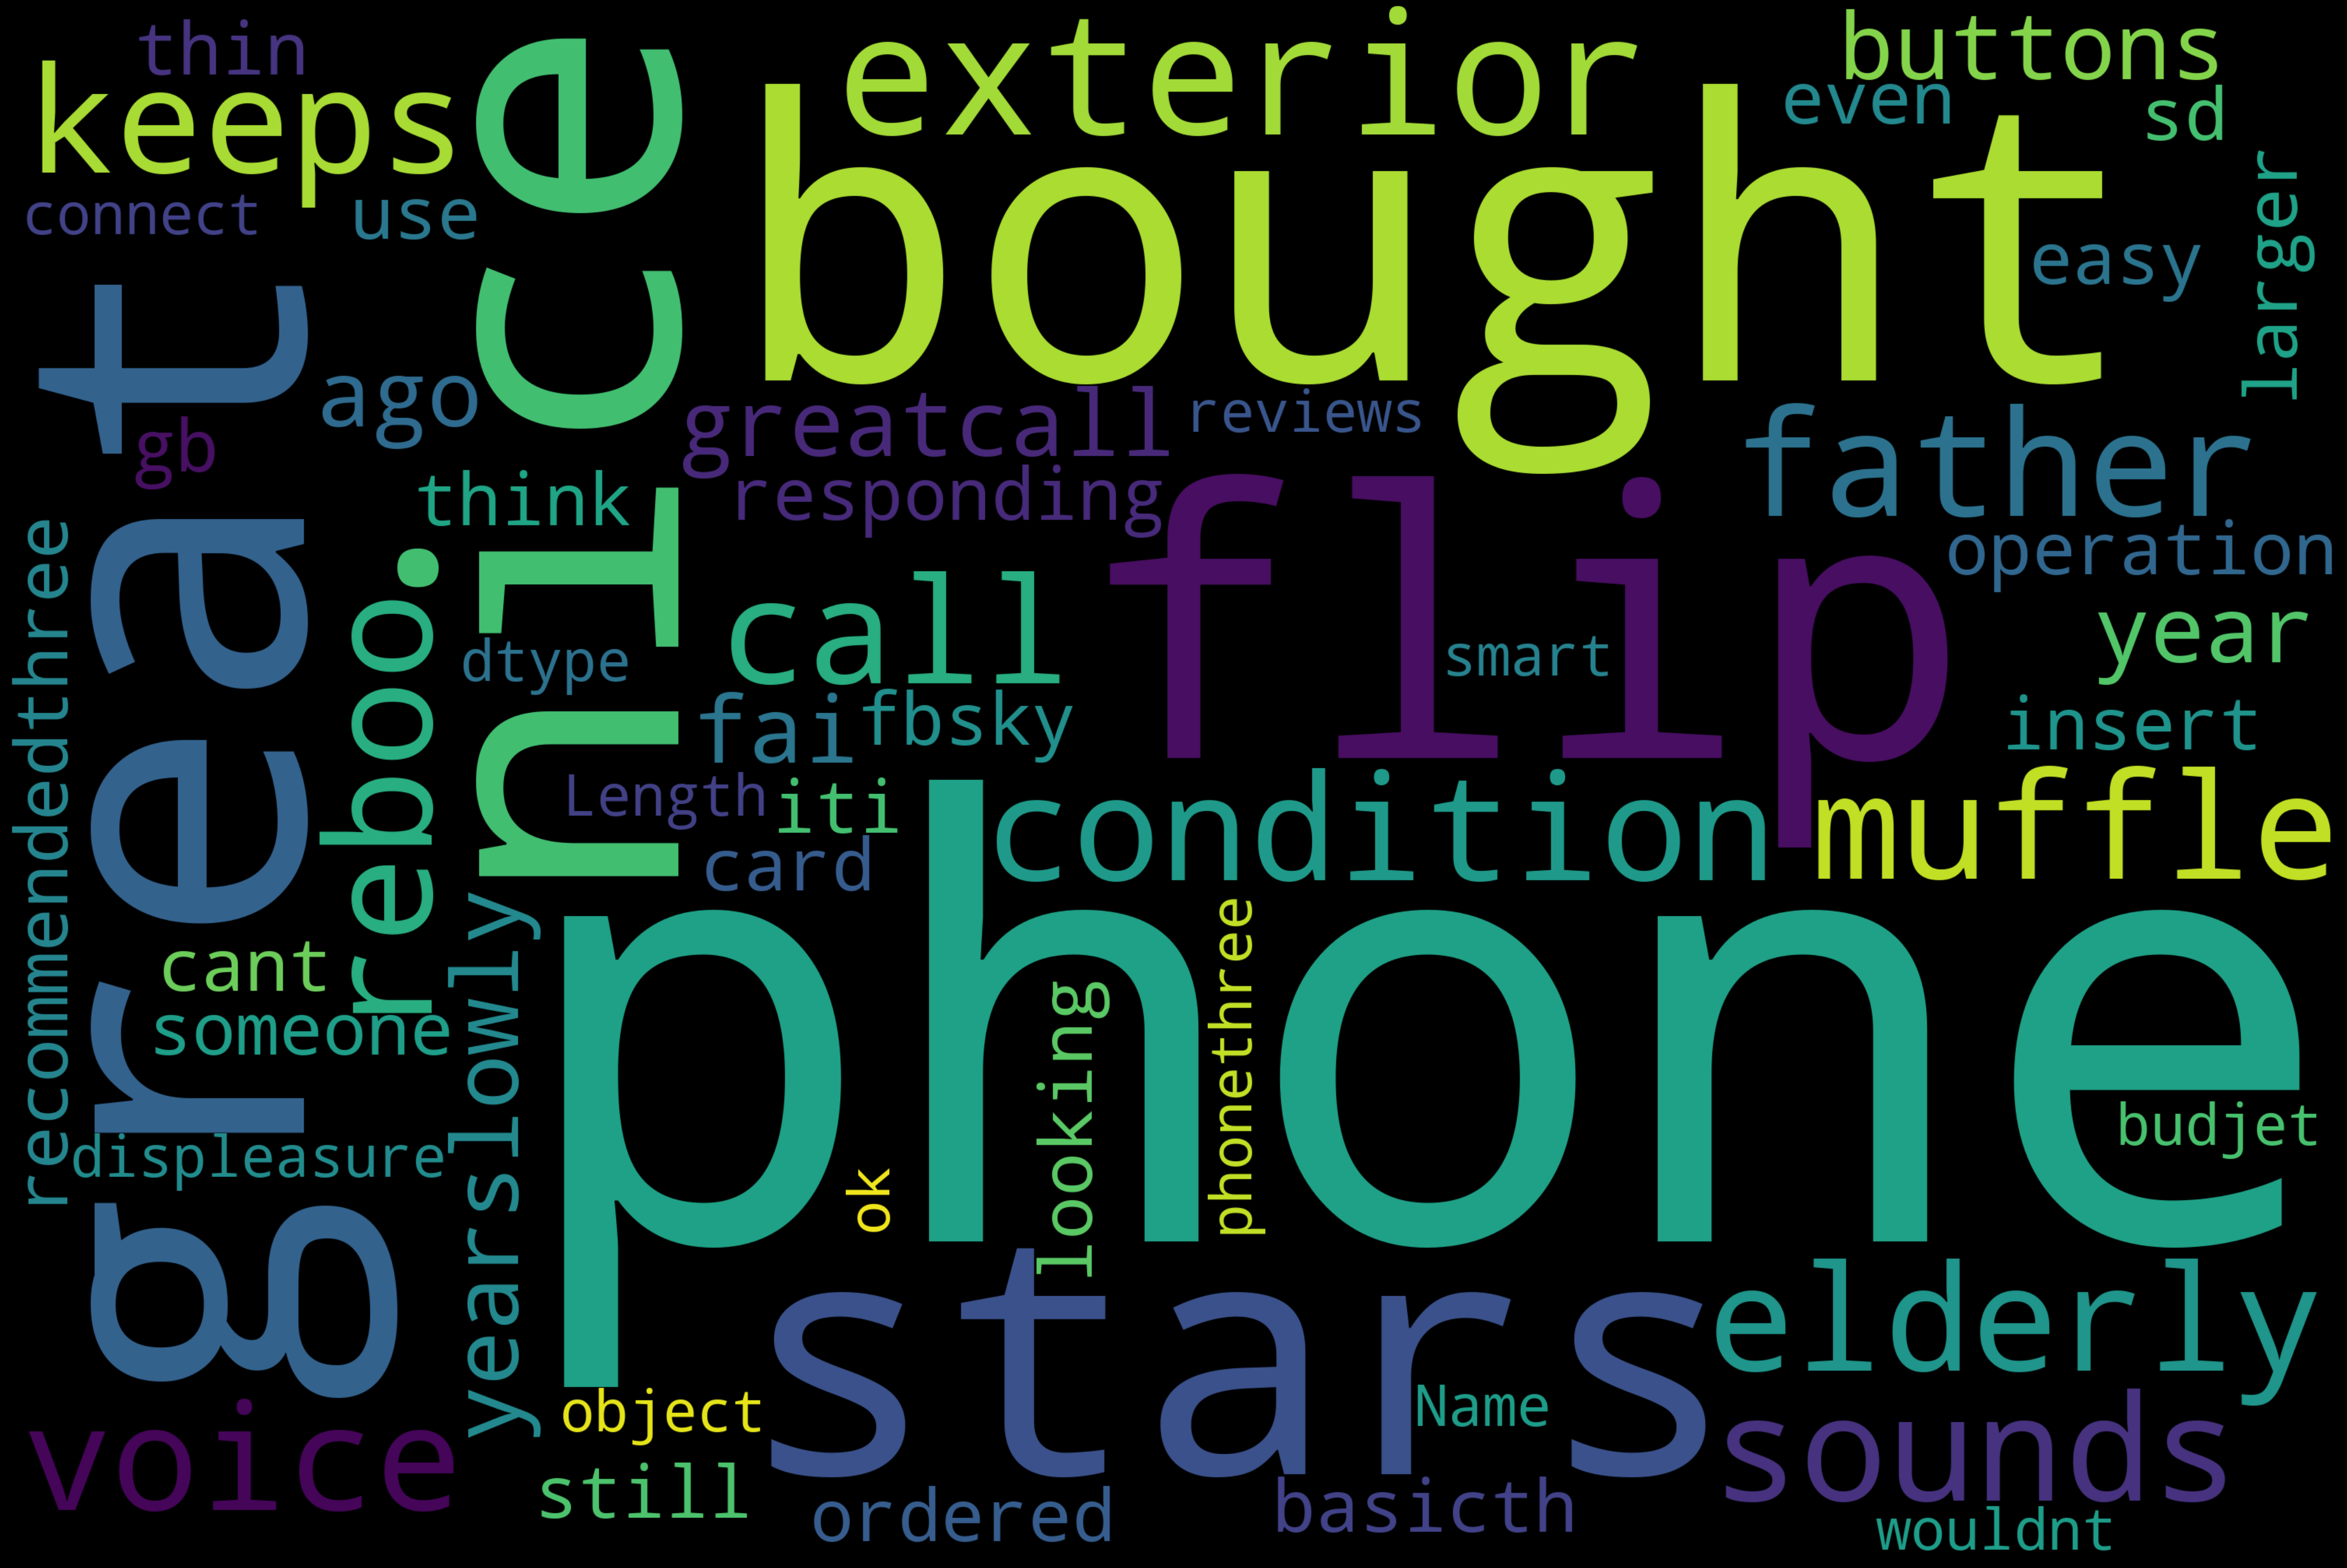

In [31]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Negative Word Cloud

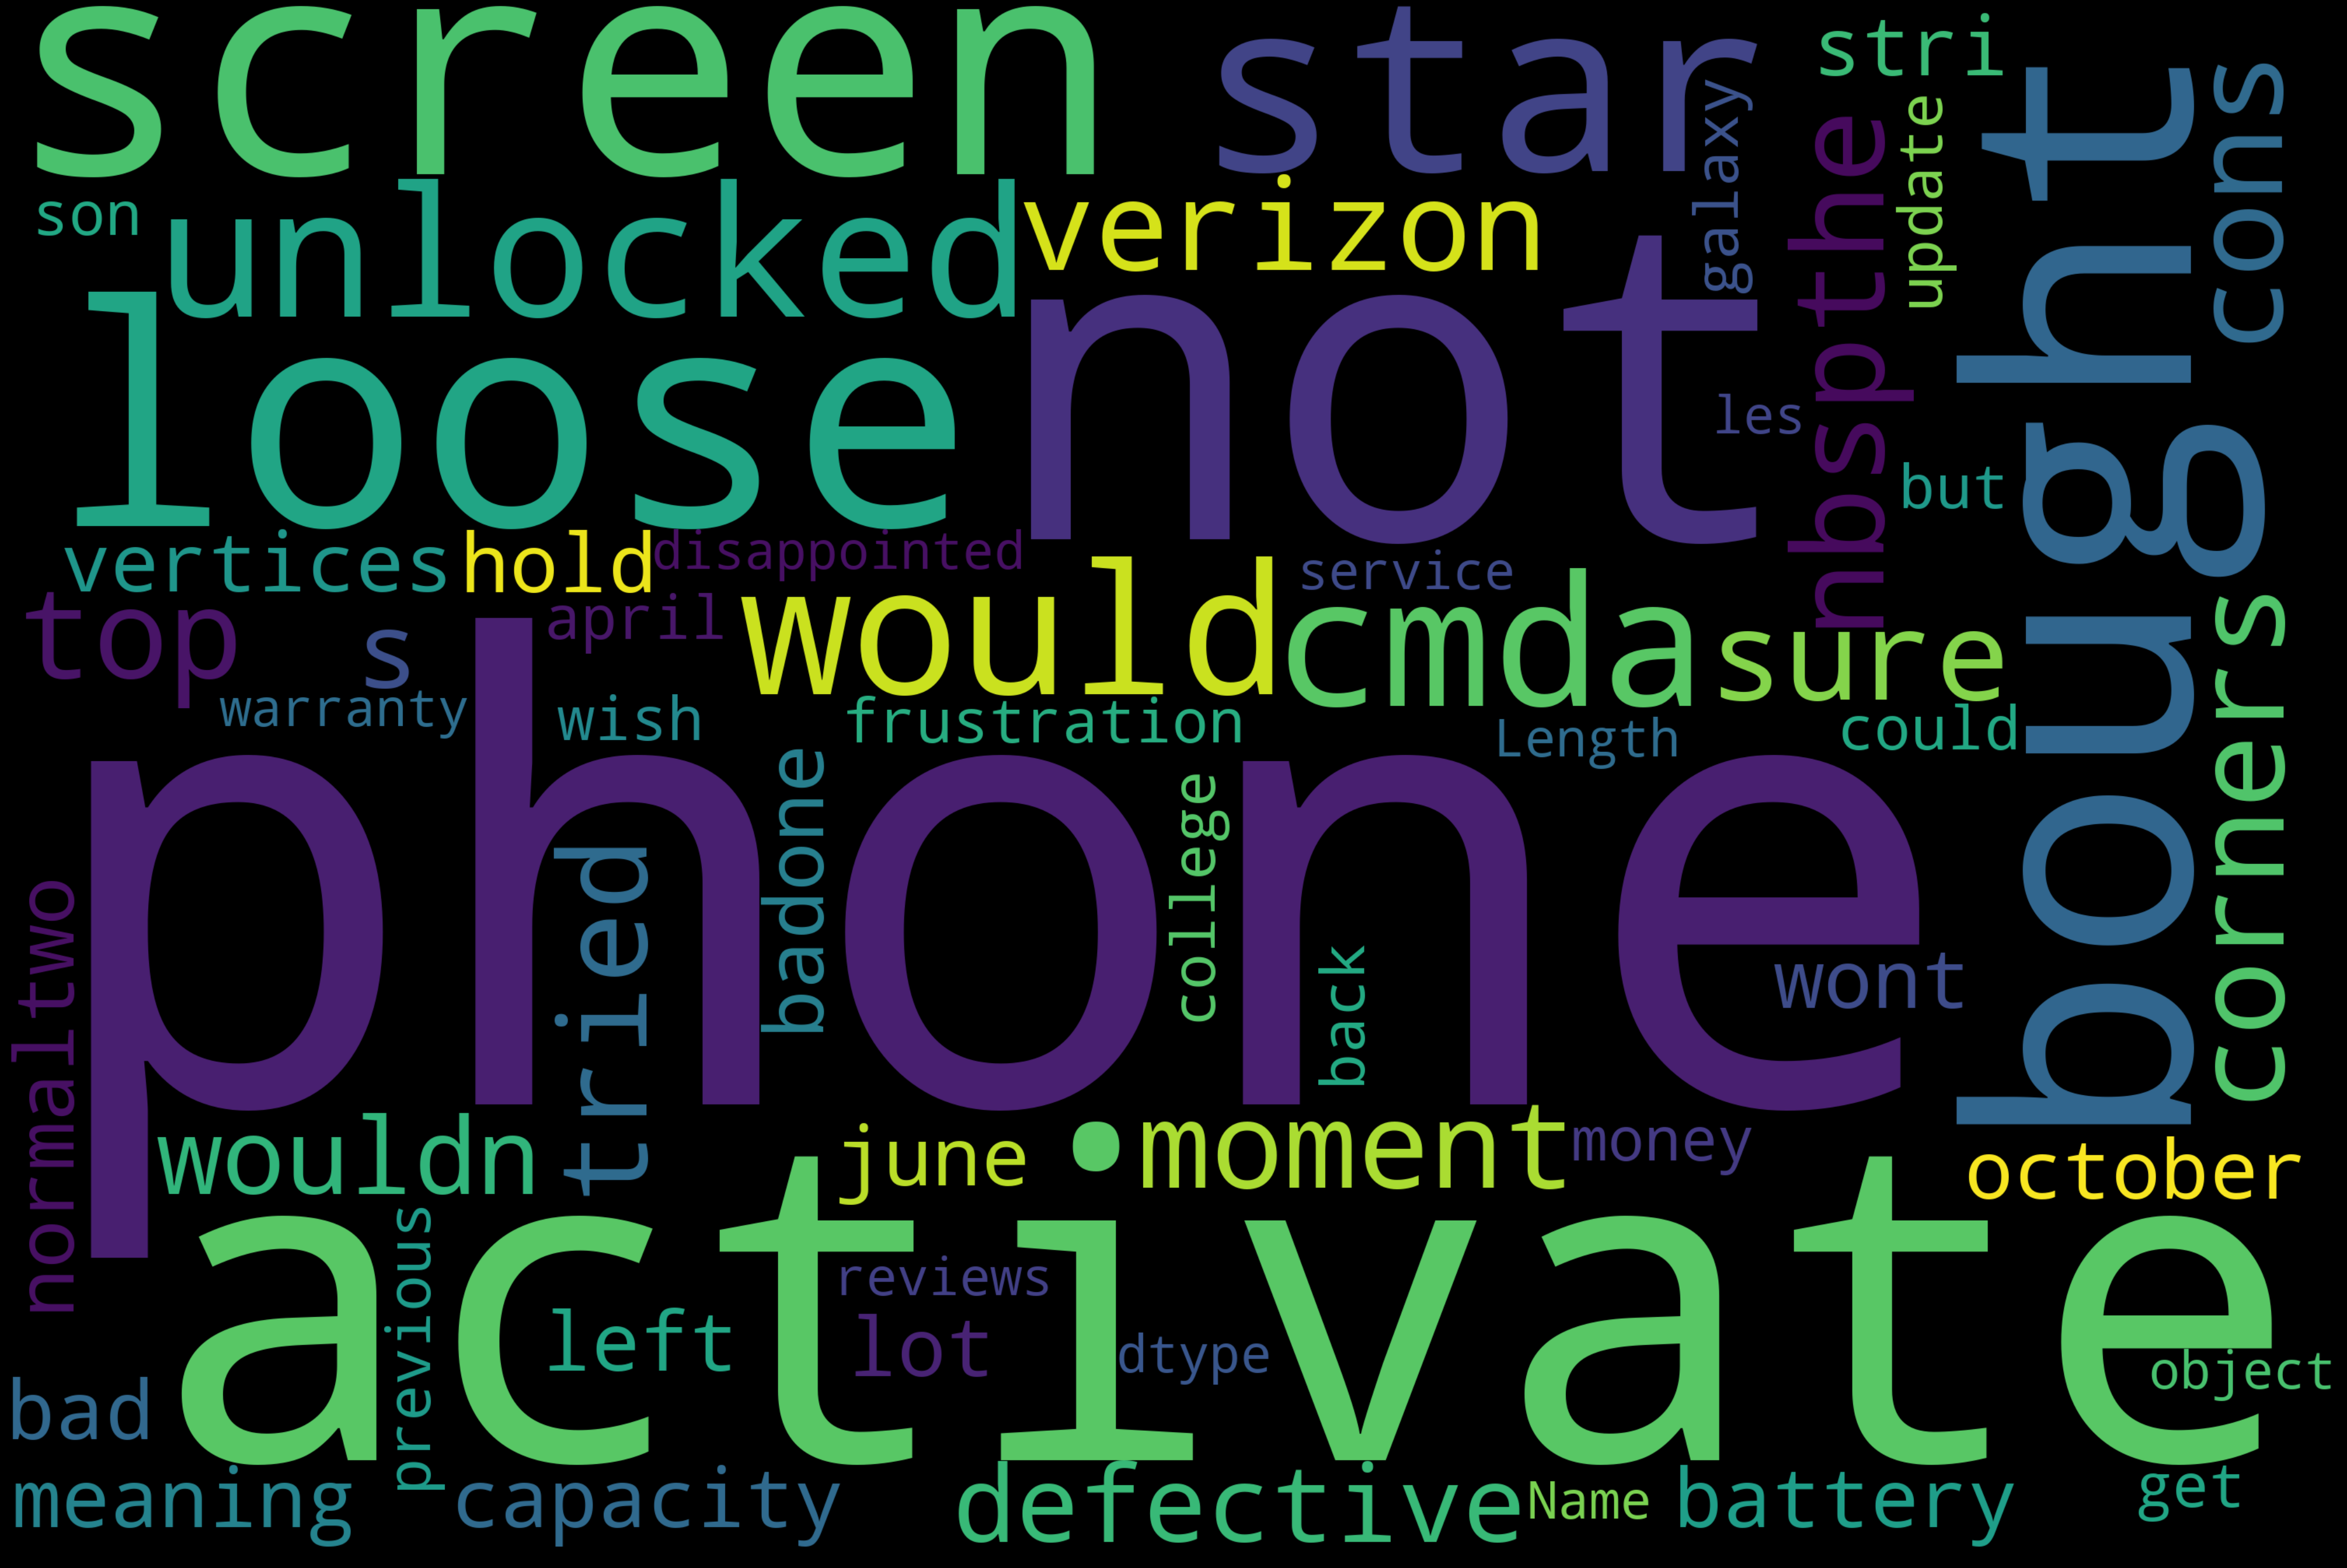

In [32]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Extracting Features from Cleaned reviews
##### Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

In [33]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['scoreSentiment']= label_encoder.fit_transform(process_reviews['scoreSentiment']) 
  
process_reviews['scoreSentiment'].unique() 

array([2, 0, 1])

In [34]:
process_reviews['scoreSentiment'].value_counts()

2    45258
0     7711
1     4379
Name: scoreSentiment, dtype: int64

### Stemming the reviews

In [35]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0               good needed lovegood product quality
1  bought phone mom looked brand new checked work...
2  phone cmda unlocked would not activate verizon...
3                                           goodnice
4                                     goodfive stars

In [36]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

In [37]:
corpus[0]

'good need lovegood product qualiti'

### TFIDF(Term Frequency — Inverse Document Frequency)

In [46]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])
X.shape

(57348, 5000)

In [41]:
#Getting the target variable(encoded)
y=process_reviews['scoreSentiment']

### Handling Imbalance target feature-SMOTE

In [70]:
# not able to do due to importing issue

### Sentiment Analysis

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [48]:
# creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
# knn_cv=KNeighborsClassifier()
# svc_cv=SVC()
nb_cv=BernoulliNB()
# cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2: 'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8524621364053389
Decision Tree Test Accuracy: 0.8041253642674707
Naive Bayes Test Accuracy: 0.7668782152315574


In [ ]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()